In [100]:
import pandas as pd

train = pd.read_csv("train.tsv")
test = pd.read_csv("test.tsv")
sample_submission = pd.read_csv("sample_submission.tsv")
train = train.drop("Num", axis=1)
frac = 0.2 # fraction of learning examples used for model fitting

# sample the train set if your don't want to deel with all examples
train = train.sample(frac=frac, random_state=42)
train = train.reset_index().drop('index', axis=1)
test = test.drop("Num", axis=1)

In [101]:
import xgboost

In [13]:
train.head()

,y,year,week,shift,item_id,f1,f2,f3,f4,f5,...,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60
0,160500,2014,13,1,20452327,129441.0,104610.0,121114.0,133780.0,122580.0,...,95880.0,88520.0,107270.0,79610.0,99210.0,114561.0,93790.0,98070.0,83980.0,105240.0
1,13107,2014,23,1,20441989,4162.0,6760.0,7210.0,11330.0,6950.0,...,9932.0,8908.0,10464.0,7431.0,10334.0,11548.0,8698.0,8696.0,8160.0,7570.0
2,53402,2013,21,3,20438706,24931.0,30338.0,30690.0,37930.0,21420.0,...,34475.0,22390.0,27124.0,29660.0,30105.0,28054.0,31545.0,28185.0,34890.0,28790.0
3,9676,2013,15,2,20438591,11505.0,13550.0,15360.0,14750.0,12961.0,...,10920.0,14030.0,8060.0,8430.0,9980.0,13930.0,6340.0,7810.0,8960.0,10260.0
4,1336,2014,3,2,20449525,0.0,0.0,0.0,0.0,0.0,...,2090.0,2470.0,1145.0,2955.0,3915.0,740.0,2260.0,1403.0,1417.0,980.0


In [102]:
from matplotlib.colors import ListedColormap
from sklearn import model_selection, datasets, linear_model, metrics
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import numpy as np
import math
import xgboost as xgb
import scipy.stats as sps

from xgboost.sklearn import XGBRegressor  
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as opt

In [514]:
def clean_data(data):
    for i in data.index.values:
#         print(data.loc[i])
        if pd.isnull(data.loc[i].values.any()):
            data = data.drop(i, axis=0)
    return data

In [259]:
train = clean_data(train)

In [77]:
def process_data(data):
    good_train = pd.DataFrame()
    created = False
    indices = []
    for i in data.index.values:
        t = data.loc[i]
        w = int(t['week'])
        y = int(t['year'])
        ans = int(t['y'])
        iid = int(t['item_id'])
        filtered = data.query('item_id == {}'.format(iid)).query('year == {}'.format(y))
        filtered= filtered[filtered.apply(lambda x: x['week'] - x['shift'] == w, axis=1)]
        if filtered.shape[0] > 0:
            if (filtered.shape[0] > 1):
                filtered = filtered[0:1]
            indices.append(i)
            new_row = filtered
#             new_row = new_row.reset_index([i]).drop('index', axis=1)
#             print(new_row)
            new_row = new_row.drop('shift', axis=1)
            new_row['week'] = w
            new_row['y'] = ans
#             new_row = new_row.drop(new_row.columns[0], axis=1)
            if created:
                good_train = pd.concat((good_train, new_row))
            else:
                good_train = new_row
                created = True
#     good_train = good_train.reset_index().drop('index', axis=1)
    return good_train, np.array(indices)

In [15]:
regressor4 = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=43)
regressor3 = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=43)


In [103]:
train_good, indices = process_data(train)

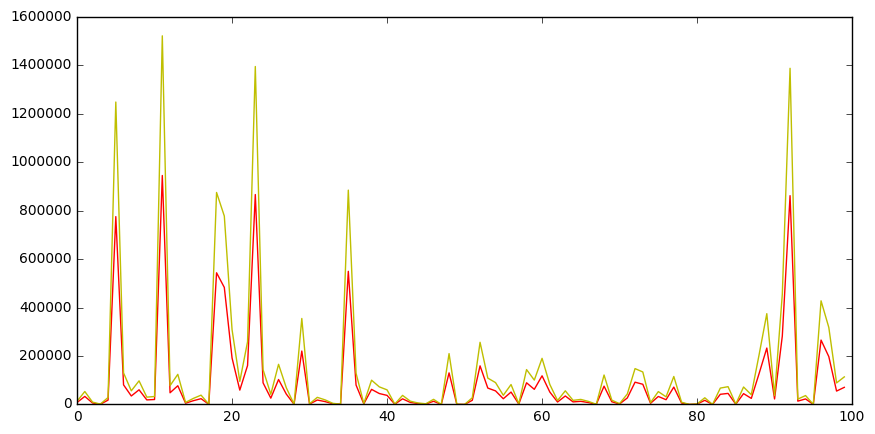

In [104]:
f = plt.figure(figsize=(10, 5))
plt.plot(range(100), train_good['f30'][0:100], c='r')
plt.plot(range(100), train_good['y'][0:100], c ='y')

да у нас просто есть ответы в данных! запустим линейную модель на 30-ом признаке. что-то пошло не так, SMAPE 39.

In [11]:
train.query('year==2014').query('item_id==20427450')

,y,year,week,shift,item_id,f1,f2,f3,f4,f5,...,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60
126,82246,2014,10,1,20427450,58042.0,60820.0,63293.0,67251.0,52722.0,...,84338.0,58455.0,22610.0,46451.0,46791.0,64224.0,42540.0,45726.0,53409.0,52905.0
259,98960,2014,24,2,20427450,30795.0,52521.0,53403.0,75986.0,39886.0,...,57315.0,56865.0,55586.0,52972.0,58383.0,76614.0,60869.0,59450.0,65365.0,83152.0
605,123348,2014,18,2,20427450,64234.0,54075.0,50841.0,55680.0,53272.0,...,45726.0,53409.0,52905.0,51085.0,44700.0,53110.0,57315.0,56865.0,55586.0,52972.0
673,85507,2014,12,2,20427450,60820.0,63293.0,67251.0,52722.0,52625.0,...,58455.0,22610.0,46451.0,46791.0,64224.0,42540.0,45726.0,53409.0,52905.0,51085.0


In [105]:
train_y = train_good['y']
train_x = train_good.drop('y', axis=1)

In [106]:
train_x_bad = train.drop('y', axis=1)
train_y_bad = train['y']

In [107]:
train_y_bad.shape

(14491,)

In [108]:
train_y_bad.shape

(14491,)

In [109]:
train_x.shape

(6575, 63)

In [110]:
train_y_log = np.array([math.log(y_i) for y_i in train_y])

In [111]:
train_y_bad_log = np.array([math.log(y_i) for y_i in train_y_bad])

In [112]:
train_x_feauture = pd.DataFrame(train_x['f30'])

In [87]:
linreg = linear_model.LinearRegression()
linreg.fit(train_x_feauture, train_y_log)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [113]:
regressor7 = XGBRegressor(max_depth=5, n_estimators=100)
regressor7 .fit(train_x_feauture, train_y_log)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [32]:
cv_params = {'max_depth': [3,5,7],'n_estimators': [70, 80, 100]}
ind_params = {'learning_rate': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'reg:linear'}

In [33]:
xgbreg = XGBRegressor(**ind_params)

In [121]:
regressor5 = XGBRegressor(max_depth=5, n_estimators=100)
regressor5 .fit(train_x, train_y_log)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [122]:
regressor6 = XGBRegressor(max_depth=5, n_estimators=100)
regressor6 .fit(train_x_bad, train_y_bad_log)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [201]:
gs1 = GridSearchCV(xgbreg, cv_params, scoring=metrics.make_scorer(metrics.mean_absolute_error))
gs1.fit(train_x, train_y_log)

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [70, 80, 100], 'min_child_weight': [1, 3, 5], 'max_depth': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(mean_absolute_error), verbose=0)

In [202]:
gs2 = GridSearchCV(xgbreg, cv_params, n_jobs=1) 
gs2.fit(train_x_bad, train_y_bad_log)

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [70, 80, 100], 'min_child_weight': [1, 3, 5], 'max_depth': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [208]:
regressor4 = GradientBoostingRegressor()
gs4 = GridSearchCV(regressor4, cv_params, scoring=metrics.make_scorer(metrics.mean_absolute_error))
gs4.fit(train_x, train_y_log)
# regressor4.fit(train_x_bad, train_y_bad_log)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [70, 80, 100], 'max_depth': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(mean_absolute_error), verbose=0)

In [221]:
regressor4 = GradientBoostingRegressor(max_depth=5, n_estimators=100)
regressor4 .fit(train_x, train_y_log)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [224]:
regressor3 = GradientBoostingRegressor(max_depth=5, n_estimators=100)
regressor3 .fit(train_x_bad, train_y_bad_log)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [209]:
regressor3 = GradientBoostingRegressor()
gs3 = GridSearchCV(regressor4, cv_params, scoring=metrics.make_scorer(metrics.mean_absolute_error))
gs3.fit(train_x_bad, train_y_bad_log)
# regressor3 = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=43)
# regressor3.fit(train_x, train_y_log)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [70, 80, 100], 'max_depth': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(mean_absolute_error), verbose=0)

In [43]:
def combine_solutions(cool_reg, simple_reg, test, processed_test, processed_indices):
    y = simple_reg.predict(test)
    cool_y = cool_reg.predict(processed_test)
    for i, ind in enumerate(processed_indices):
        y[ind] = cool_y[i]
    return y

In [48]:
def combine_solutions_feature(cool_reg, simple_reg, test, processed_test, processed_indices):
    y = simple_reg.predict(test)
    processed_test_feature = pd.DataFrame(processed_test['f30'])
    cool_y = cool_reg.predict( processed_test_feature)
    for i, ind in enumerate(processed_indices):
        y[ind] = cool_y[i]
    return y

In [44]:
def process_test(data):
    good_train = pd.DataFrame()
    created = False
    indices = []
    for i in data.index.values:
        t = data.loc[i]
        w = int(t['week'])
        y = int(t['year'])
        iid = int(t['item_id'])
        filtered = data.query('item_id == {}'.format(iid)).query('year == {}'.format(y))
        filtered= filtered[filtered.apply(lambda x: x['week'] - x['shift'] == w, axis=1)]
        if filtered.shape[0] > 0:
            if (filtered.shape[0] > 1):
                filtered = filtered[0:1]
            indices.append(i)
            new_row = filtered
#             new_row = new_row.reset_index([i]).drop('index', axis=1)
#             print(new_row)
            new_row = new_row.drop('shift', axis=1)
            new_row['week'] = w
#             new_row = new_row.drop(new_row.columns[0], axis=1)
            if created:
                good_train = pd.concat((good_train, new_row))
            else:
                good_train = new_row
                created = True
#     good_train = good_train.reset_index().drop('index', axis=1)
    return good_train, np.array(indices)

In [64]:
test = train[0:2000].drop('y', axis=1).reset_index().drop('index', axis=1)

In [65]:
test_x, indices_test = process_test(test)

In [225]:
y_final = combine_solutions(regressor4, regressor3, test, test_x, indices_test)
y_final = np.array([math.exp(y_i) for y_i in y_final])

In [218]:
y2_final = combine_solutions(gs1, gs3, test, test_x, indices_test)
y2_final = np.array([math.exp(y_i) for y_i in y2_final])

In [123]:
y3_final = combine_solutions(regressor5, regressor6, test, test_x, indices_test)
y3_final = np.array([math.exp(y_i) for y_i in y3_final])

In [89]:
y4_final = combine_solutions_feature(linreg, regressor6, test, test_x, indices_test)
y4_final = np.array([math.exp(y_i) for y_i in y4_final])

In [118]:
y5_final = combine_solutions_feature(regressor7, regressor6, test, test_x, indices_test)
y5_final = np.array([math.exp(y_i) for y_i in y5_final])

In [124]:
sample_submission['y'] = y3_final

In [125]:
sample_submission.to_csv("my_submission_log_xgb.tsv", sep=',', index=False)

In [82]:
train_x_check, train_indices_check = process_test(train_x_bad[0:1000])

In [66]:
y_real = train[0:2000]['y']

In [93]:
pred = combine_solutions(gs1, gs2, train_x_bad[0:1000], train_x_check, train_indices_check)

In [94]:
pred2 = combine_solutions(regressor3, regressor4, train_x_bad[0:1000], train_x_check, train_indices_check)

In [226]:
metrics.mean_absolute_error(y_final, y_real)

21124.200013660262

In [219]:
metrics.mean_absolute_error(y2_final, y_real)

28695.494061718658

In [73]:
metrics.mean_absolute_error(y4_final, y_real)

31471.102919226669